In [16]:
# !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
# !pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm as std_tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

PyTorch version: 2.0.0
MPS available: True
MPS built: True


[nltk_data] Downloading package punkt to /Users/peeti_mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peeti_mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Define the CircuitNoteDataset class
class CircuitNoteDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize and convert to indices
        tokens = self.tokenizer.tokenize(text)
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        
        # Pad or truncate to max_len
        if len(token_ids) < self.max_len:
            token_ids = token_ids + [0] * (self.max_len - len(token_ids))
        else:
            token_ids = token_ids[:self.max_len]
            
        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [3]:
class SimpleTokenizer:
    def __init__(self, texts, max_vocab=10000):
        # Create vocabulary from texts
        try:
            from nltk.corpus import stopwords
            self.stop_words = set(stopwords.words('english'))
        except (ImportError, LookupError):
            # Fallback to a simple list of common stopwords
            self.stop_words = self._get_basic_stopwords()
            
        all_words = []
        
        for text in texts:
            words = self.preprocess_text(text)
            all_words.extend(words)
            
        # Count word frequencies
        from collections import Counter
        word_counts = Counter(all_words)
        
        # Build vocabulary (most common words + special tokens)
        vocab_words = [word for word, _ in word_counts.most_common(max_vocab-3)]
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<CLS>': 2}
        for i, word in enumerate(vocab_words):
            self.word2idx[word] = i + 3
            
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        # Make sure vocab_size is properly set
        self.vocab_size = len(self.word2idx)
        print(f"Vocabulary size: {self.vocab_size}")
        
    def _get_basic_stopwords(self):
        # Basic list of English stopwords
        return set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
                   'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 
                   'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 
                   'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
                   'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 
                   'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 
                   'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
                   'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 
                   'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 
                   'into', 'through', 'during', 'before', 'after', 'above', 'below', 
                   'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 
                   'under', 'again', 'further', 'then', 'once', 'here', 'there', 
                   'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 
                   'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 
                   'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 
                   't', 'can', 'will', 'just', 'don', 'should', 'now'])
    
    def preprocess_text(self, text):
        # Clean and tokenize text without using NLTK's word_tokenize
        text = text.lower()
        import re
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        
        # Simple space-based tokenization
        words = text.split()
        
        # Remove stopwords
        words = [word for word in words if word not in self.stop_words]
        return words
    
    def tokenize(self, text):
        words = self.preprocess_text(text)
        return ['<CLS>'] + words
    
    def convert_tokens_to_ids(self, tokens):
        return [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]
    
    def convert_ids_to_tokens(self, ids):
        return [self.idx2word.get(id, '<UNK>') for id in ids]

In [4]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids):
        # input_ids shape: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(input_ids))
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        output, (hidden, cell) = self.lstm(embedded)
        
        # If bidirectional, concat the final forward and backward hidden states
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
            
        # hidden shape: [batch_size, hidden_dim]
        
        return self.fc(self.dropout(hidden))

In [5]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_heads, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids):
        # input_ids shape: [batch_size, seq_len]
        
        # Create mask for padding tokens
        mask = (input_ids == 0)
        
        embedded = self.dropout(self.embedding(input_ids))
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        output = self.transformer_encoder(embedded, src_key_padding_mask=mask)
        # Use the [CLS] token (first token) representation for classification
        cls_output = output[:, 0, :]
        
        return self.fc(self.dropout(cls_output))


In [6]:
# Add visualization of training progress
def plot_training_history(train_losses, valid_losses, train_accs, valid_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(valid_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracies
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(valid_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()



In [7]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, epochs=10, accumulation_steps=4):
    """Train the model and evaluate on validation set with gradient accumulation"""
    best_valid_loss = float('inf')
    # To store training history
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    
    # Early stopping parameters
    patience = 3
    early_stop_counter = 0
    
    # Use regular tqdm instead of notebook tqdm
    from tqdm import tqdm as std_tqdm
    
    try:
        for epoch in range(epochs):
            # Training
            model.train()
            train_loss = 0
            train_acc = 0
            batch_count = 0
            
            # Reset gradients
            optimizer.zero_grad()
            
            for i, batch in enumerate(std_tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training')):
                try:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['label'].to(device)
                    
                    # Forward pass
                    predictions = model(input_ids)
                    
                    # Calculate loss and scale it
                    loss = criterion(predictions, labels) / accumulation_steps
                    train_loss += loss.item() * accumulation_steps
                    
                    # Calculate accuracy
                    preds = predictions.argmax(dim=1)
                    train_acc += (preds == labels).sum().item() / len(labels)
                    
                    # Backward pass
                    loss.backward()
                    
                    # Only update weights after accumulation_steps or at the end of the loader
                    if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                        # Gradient clipping to prevent exploding gradients
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        
                        # Update parameters
                        optimizer.step()
                        
                        # Reset gradients
                        optimizer.zero_grad()
                    
                    batch_count += 1
                    
                    # Free up memory
                    del input_ids, labels, predictions, loss, preds
                    if hasattr(torch, 'cuda') and torch.cuda.is_available():
                        torch.cuda.empty_cache()
                        
                except Exception as e:
                    print(f"Error in batch {i}: {str(e)}")
                    continue
            
            # Calculate average loss and accuracy
            if batch_count > 0:  # Protect against division by zero
                train_loss /= batch_count
                train_acc /= batch_count
            else:
                print("Warning: No batches were successfully processed in this epoch")
                continue
            
            # Validation
            model.eval()
            valid_loss = 0
            valid_acc = 0
            valid_batch_count = 0
            
            with torch.no_grad():
                for batch in std_tqdm(valid_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation'):
                    try:
                        input_ids = batch['input_ids'].to(device)
                        labels = batch['label'].to(device)
                        
                        # Forward pass
                        predictions = model(input_ids)
                        
                        # Calculate loss
                        loss = criterion(predictions, labels)
                        valid_loss += loss.item()
                        
                        # Calculate accuracy
                        preds = predictions.argmax(dim=1)
                        valid_acc += (preds == labels).sum().item() / len(labels)
                        
                        valid_batch_count += 1
                        
                        # Free up memory
                        del input_ids, labels, predictions, loss, preds
                        if hasattr(torch, 'cuda') and torch.cuda.is_available():
                            torch.cuda.empty_cache()
                            
                    except Exception as e:
                        print(f"Error in validation batch: {str(e)}")
                        continue
            
            # Calculate average validation loss and accuracy
            if valid_batch_count > 0:
                valid_loss /= valid_batch_count
                valid_acc /= valid_batch_count
            else:
                print("Warning: No validation batches were successfully processed")
                continue
            
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')
            
            # Save best model
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), 'best_circuit_note_model.pt')
                print("Saved best model!")
                early_stop_counter = 0  # Reset counter when we have improvement
            else:
                early_stop_counter += 1
                print(f"No improvement for {early_stop_counter} epochs")
            
            # Store metrics
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            train_accs.append(train_acc)
            valid_accs.append(valid_acc)
            
            # Save checkpoint at intervals
            if (epoch + 1) % 2 == 0:  # Every 2 epochs
                checkpoint_path = f'checkpoint_epoch_{epoch+1}.pt'
                torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'valid_loss': valid_loss,
                    'train_acc': train_acc,
                    'valid_acc': valid_acc,
                    'best_valid_loss': best_valid_loss,
                }, checkpoint_path)
                print(f"Saved checkpoint at epoch {epoch+1}")
            
            # Early stopping
            if early_stop_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs due to no improvement in validation loss")
                break
        
        print(f"Training completed after {epoch+1} epochs")
    
    except KeyboardInterrupt:
        print("Training interrupted by user")
    except Exception as e:
        print(f"Training error: {str(e)}")
        import traceback
        traceback.print_exc()
    
    # Return training history
    return train_losses, valid_losses, train_accs, valid_accs

In [8]:
def predict_circuit_status(model, tokenizer, text, device, label_encoder):
    """Make prediction on new circuit note text"""
    model.eval()
    
    # Tokenize the input text
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # Pad or truncate to max_len (assuming max_len is 128)
    max_len = 128
    if len(token_ids) < max_len:
        token_ids = token_ids + [0] * (max_len - len(token_ids))
    else:
        token_ids = token_ids[:max_len]
    
    # Convert to tensor
    input_ids = torch.tensor([token_ids], dtype=torch.long).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(input_ids)
        prediction = output.argmax(dim=1).item()
    
    # Convert back to label
    predicted_label = label_encoder.inverse_transform([prediction])[0]
    
    return predicted_label


Creating synthetic data for demonstration...
Train size: 350, Valid size: 75, Test size: 75
Creating tokenizer...
Vocabulary size: 52
Using device: cpu (forced for stability)
Initializing Transformer model...
Training model...


Epoch 1/5 - Validation: 100%|█████████████████| 19/19 [00:00<00:00, 2052.64it/s]


Epoch 1/5:
Train Loss: 1.4310, Train Acc: 0.4062
Valid Loss: 0.7439, Valid Acc: 1.0000
Saved best model!


Epoch 2/5 - Validation: 100%|█████████████████| 19/19 [00:00<00:00, 1734.01it/s]


Epoch 2/5:
Train Loss: 0.4172, Train Acc: 0.9318
Valid Loss: 0.0189, Valid Acc: 1.0000
Saved best model!
Saved checkpoint at epoch 2


Epoch 3/5 - Validation: 100%|█████████████████| 19/19 [00:00<00:00, 1934.27it/s]


Epoch 3/5:
Train Loss: 0.0507, Train Acc: 0.9943
Valid Loss: 0.0068, Valid Acc: 1.0000
Saved best model!


Epoch 4/5 - Validation: 100%|█████████████████| 19/19 [00:00<00:00, 2114.91it/s]


Epoch 4/5:
Train Loss: 0.0221, Train Acc: 1.0000
Valid Loss: 0.0041, Valid Acc: 1.0000
Saved best model!
Saved checkpoint at epoch 4


Epoch 5/5 - Validation: 100%|█████████████████| 19/19 [00:00<00:00, 2164.77it/s]


Epoch 5/5:
Train Loss: 0.0140, Train Acc: 1.0000
Valid Loss: 0.0030, Valid Acc: 1.0000
Saved best model!
Training completed after 5 epochs


Testing: 100%|████████████████████████████████| 19/19 [00:00<00:00, 2312.25it/s]


Test Accuracy: 1.0000

Creating confusion matrix and classification report...


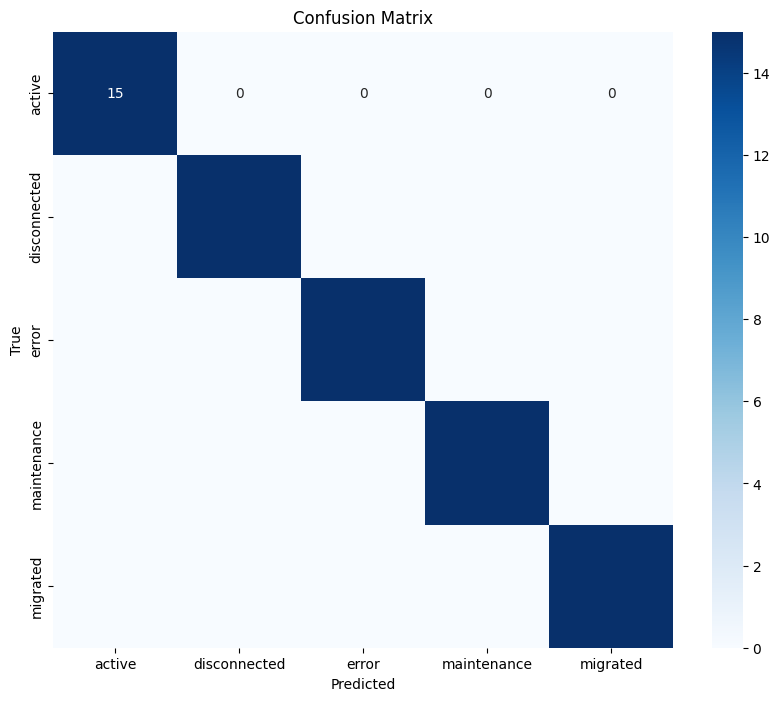

              precision    recall  f1-score   support

      active       1.00      1.00      1.00        15
disconnected       1.00      1.00      1.00        15
       error       1.00      1.00      1.00        15
 maintenance       1.00      1.00      1.00        15
    migrated       1.00      1.00      1.00        15

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75

Script execution completed!

Making predictions on sample notes:
Note: 'Circuit disconnected per customer request'
Predicted status: disconnected

Note: 'Migration completed successfully with no issues'
Predicted status: migrated

Note: 'Error detected during testing phase'
Predicted status: error

Note: 'Active and stable with no packet loss'
Predicted status: active

Note: 'Maintenance scheduled for next Tuesday'
Predicted status: maintenance

Script execution completed!


In [11]:
def main():
    # Assume we have a DataFrame with columns 'note_text' and 'status'
    # where status can be 'disconnected', 'migrated', 'error', etc.
    
    # Example code to load data (replace with actual data loading)
    # df = pd.read_csv('circuit_notes.csv')
    
    # For demonstration, let's create some synthetic data
    print("Creating synthetic data for demonstration...")
    
    circuit_statuses = ['disconnected', 'migrated', 'error', 'active', 'maintenance']
    
    # Create synthetic data - in practice, replace this with your real data
    notes = [
        "Circuit was disconnected due to customer request on 5/10",
        "Successfully migrated from old platform to new one",
        "Error reported: packet loss exceeding 5% during peak hours",
        "Circuit active and functioning within normal parameters",
        "Scheduled maintenance completed. All tests passed.",
        "Customer requested disconnection due to relocation",
        "Migration of services completed with no downtime",
        "Error code 404 received when testing connection",
        "Active monitoring shows stable connection",
        "Maintenance window extended due to firmware update issues"
    ] * 50  # Replicate to get a larger dataset
    
    statuses = []
    for note in notes:
        if 'disconnect' in note.lower():
            statuses.append('disconnected')
        elif 'migrat' in note.lower():
            statuses.append('migrated')
        elif 'error' in note.lower():
            statuses.append('error')
        elif 'active' in note.lower():
            statuses.append('active')
        elif 'maintenance' in note.lower():
            statuses.append('maintenance')
        else:
            # Just in case we missed something
            statuses.append(np.random.choice(circuit_statuses))
    
    # Create DataFrame
    df = pd.DataFrame({
        'note_text': notes,
        'status': statuses
    })
    
    # Encode labels
    label_encoder = LabelEncoder()
    df['status_encoded'] = label_encoder.fit_transform(df['status'])
    
    # Split data
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        df['note_text'].values, 
        df['status_encoded'].values,
        test_size=0.3,
        random_state=42,
        stratify=df['status_encoded']
    )
    
    valid_texts, test_texts, valid_labels, test_labels = train_test_split(
        temp_texts,
        temp_labels,
        test_size=0.5,
        random_state=42,
        stratify=temp_labels
    )
    
    print(f"Train size: {len(train_texts)}, Valid size: {len(valid_texts)}, Test size: {len(test_texts)}")
    
    # Create tokenizer
    print("Creating tokenizer...")
    tokenizer = SimpleTokenizer(train_texts, max_vocab=5000)
    
    # Hyperparameters
    
    MAX_LEN = 32
    BATCH_SIZE = 4
    EMBEDDING_DIM = 64


    HIDDEN_DIM = 128
    OUTPUT_DIM = len(label_encoder.classes_)
    N_LAYERS = 1
    BIDIRECTIONAL = True
    N_HEADS = 8  # For transformer
    DROPOUT = 0.2
    EPOCHS = 5
    LEARNING_RATE = 0.001

    
    # Create datasets
    train_dataset = CircuitNoteDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    valid_dataset = CircuitNoteDataset(valid_texts, valid_labels, tokenizer, MAX_LEN)
    test_dataset = CircuitNoteDataset(test_texts, test_labels, tokenizer, MAX_LEN)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # # Set device - optimized for Apple Silicon
    # if torch.backends.mps.is_available():
    #     device = torch.device("mps")
    # elif torch.cuda.is_available():
    #     device = torch.device("cuda")
    # else:
    #     device = torch.device("cpu")
    # print(f"Using device: {device}")
    device = torch.device("cpu")
    print(f"Using device: {device} (forced for stability)")
    
    # Choose model type based on preference (LSTM or Transformer)
    model_type = "transformer"  # Change to "lstm" if you prefer LSTM
    
    if model_type == "lstm":
        print("Initializing LSTM model...")
        model = LSTMClassifier(
            vocab_size=tokenizer.vocab_size,
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=OUTPUT_DIM,
            n_layers=N_LAYERS,
            bidirectional=BIDIRECTIONAL,
            dropout=DROPOUT
        )
    else:
        print("Initializing Transformer model...")
        model = TransformerClassifier(
            vocab_size=tokenizer.vocab_size,
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM * 4,  # Transformer typically uses larger feedforward layer
            output_dim=OUTPUT_DIM,
            n_heads=N_HEADS,
            n_layers=N_LAYERS,
            dropout=DROPOUT
        )
    
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Train model

    print("Training model...")
    train_losses, valid_losses, train_accs, valid_accs = train_model(
        model, train_loader, valid_loader, criterion, optimizer, device, 
        epochs=EPOCHS, accumulation_steps=4
    )

    
    # Load best model
    model.load_state_dict(torch.load('best_circuit_note_model.pt'))
    
    # Evaluate on test set
    model.eval()
    test_acc = 0
    test_preds = []
    test_true = []
    
    with torch.no_grad():
        
        for batch in std_tqdm(test_loader, desc='Testing'):
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            predictions = model(input_ids)
            
            # Calculate accuracy
            preds = predictions.argmax(dim=1)
            test_acc += (preds == labels).sum().item() / len(labels)
            
            test_preds.extend(preds.cpu().numpy())
            test_true.extend(labels.cpu().numpy())
    
    test_acc /= len(test_loader)
    print(f'Test Accuracy: {test_acc:.4f}')

    # Visualize confusion matrix
    def plot_confusion_matrix(y_true, y_pred, classes):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix.png')  # Save the figure
        plt.show()
        
        # Print classification report
        print(classification_report(y_true, y_pred, target_names=classes))
    
    # Create confusion matrix and classification report
    print("\nCreating confusion matrix and classification report...")
    plot_confusion_matrix(
        [label_encoder.inverse_transform([label])[0] for label in test_true],
        [label_encoder.inverse_transform([pred])[0] for pred in test_preds],
        label_encoder.classes_
    )
    
    print("Script execution completed!")
    
    # Example of making predictions with the trained model
    sample_notes = [
        "Circuit disconnected per customer request",
        "Migration completed successfully with no issues",
        "Error detected during testing phase",
        "Active and stable with no packet loss",
        "Maintenance scheduled for next Tuesday"
    ]
    
    print("\nMaking predictions on sample notes:")
    for note in sample_notes:
        predicted_status = predict_circuit_status(model, tokenizer, note, device, label_encoder)
        print(f"Note: '{note}'")
        print(f"Predicted status: {predicted_status}\n")
    
    print("Script execution completed!")

if __name__ == "__main__":
    main()
